((1000, 5), (1000, 5))

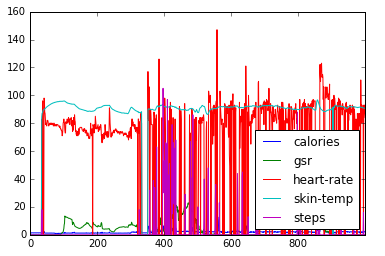

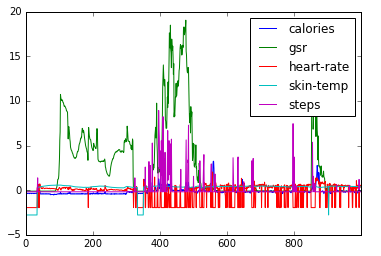

In [1]:
# Data: time-serie data from smartwatch or smartwatch data
%matplotlib inline
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Data reading
# The smartwatch historical/time-seris data to visualize
data_path_1xn = 'data/smartwatch_data/experimental_data_analysis/Basis_Watch_Data.csv'
watch_txn = pd.read_csv(data_path_1xn)

# Data: cleaning
# Getting rid of NaN
watch_txn = watch_txn.fillna(value=0.0)

# # Plotting the smartwatch data before scaling/batch normalization
watch_txn[:1000].plot() #x='dteday', y='cnt'

# Data: Preprocessing 
# Batch normalization
features_1x5 = ['calories', 'gsr', 'heart-rate', 'skin-temp', 'steps']
scaled_features_5x2 = {}
for each_name in features_1x5:
    mean_1x1_val, std_1x1_val = watch_txn[each_name].mean(), watch_txn[each_name].std() # std: standard dev. = square-root of MSE/Variance
    scaled_features_5x2[each_name] = [mean_1x1_val, std_1x1_val]
    watch_txn.loc[:, each_name] = (watch_txn[each_name] - mean_1x1_val)/std_1x1_val

# Drop date from the dataset
watch_txn = watch_txn.drop(labels='date', axis=1)

# ploting the data after scaling or batch normalization
watch_txn[:1000].plot()

# Sequence learning - seq2seq learning - Unsupervised Learning
# Training
X_train = np.array(watch_txn[:-2000])
Y_train = np.array(watch_txn[1:-2000+1])
X_train.shape, Y_train.shape

# Validation
X_valid = np.array(watch_txn[-2000:-1000])
Y_valid = np.array(watch_txn[-2000+1:-1000+1])
X_valid.shape, Y_valid.shape

# Testing
X_test = np.array(watch_txn[-1000:])
Y_test = np.array(watch_txn[-1000+1:])
last_row = np.array([np.zeros_like(Y_test[0])])
Y_test = np.row_stack((Y_test, last_row))
X_test.shape, Y_test.shape

In [2]:
# Model
import impl.loss as loss_fun
import impl.layer as l
import impl.utils as util
import impl.NN as nn

class LSTM(nn.NN):

    def __init__(self, D, H, L):
        self.D = D
        self.H = H
        self.L = L
        self.losses = {'train':[], 'valid':[], 'test':[]}
        super().__init__(D, D, H, None, None, loss='cross_ent', nonlin='relu')

    def _init_model(self, D, C, H):
        Z = H + D
        m = dict(
            Wf=np.random.randn(Z, H) / np.sqrt(Z / 2.),
            Wi=np.random.randn(Z, H) / np.sqrt(Z / 2.),
            Wc=np.random.randn(Z, H) / np.sqrt(Z / 2.),
            Wo=np.random.randn(Z, H) / np.sqrt(Z / 2.),
            Wy=np.random.randn(H, D) / np.sqrt(D / 2.),
            bf=np.zeros((1, H)),
            bi=np.zeros((1, H)),
            bc=np.zeros((1, H)),
            bo=np.zeros((1, H)),
            by=np.zeros((1, D)))

        self.model = []
        for l in range(self.L):
            self.model.append(m)

    def initial_state(self):
        return (np.zeros((1, self.H)), np.zeros((1, self.H)))

    def forward(self, X, h, m):
        Wf, Wi, Wc, Wo, Wy = m['Wf'], m['Wi'], m['Wc'], m['Wo'], m['Wy']
        bf, bi, bc, bo, by = m['bf'], m['bi'], m['bc'], m['bo'], m['by']

        h_old, c_old = h
        X_one_hot = X.copy()

        X = np.column_stack((h_old, X_one_hot))

        hf, hf_cache = l.fc_forward(X, Wf, bf)
        hf, hf_sigm_cache = l.sigmoid_forward(hf)

        hi, hi_cache = l.fc_forward(X, Wi, bi)
        hi, hi_sigm_cache = l.sigmoid_forward(hi)

        ho, ho_cache = l.fc_forward(X, Wo, bo)
        ho, ho_sigm_cache = l.sigmoid_forward(ho)

        hc, hc_cache = l.fc_forward(X, Wc, bc)
        hc, hc_tanh_cache = l.tanh_forward(hc)

        c = hf * c_old + hi * hc
        c, c_tanh_cache = l.tanh_forward(c)

        h = ho * c

        y, y_cache = l.fc_forward(h, Wy, by)
        h = (h, c)

        cache = (
            X, hf, hi, ho, hc, hf_cache, hf_sigm_cache, hi_cache, hi_sigm_cache, ho_cache,
            ho_sigm_cache, hc_cache, hc_tanh_cache, c_old, c, c_tanh_cache, y_cache
        )
        return y, h, cache

    def backward(self, dy, dh, cache):
        X, hf, hi, ho, hc, hf_cache, hf_sigm_cache, hi_cache, hi_sigm_cache, ho_cache, ho_sigm_cache, hc_cache, hc_tanh_cache, c_old, c, c_tanh_cache, y_cache = cache
        dh_next, dc_next = dh

        dh, dWy, dby = l.fc_backward(dy, y_cache)
        dh += dh_next

        dho = c * dh
        dho = l.sigmoid_backward(dho, ho_sigm_cache)

        dc = ho * dh
        dc = l.tanh_backward(dc, c_tanh_cache)
        dc = dc + dc_next

        dhf = c_old * dc
        dhf = l.sigmoid_backward(dhf, hf_sigm_cache)

        dhi = hc * dc
        dhi = l.sigmoid_backward(dhi, hi_sigm_cache)

        dhc = hi * dc
        dhc = l.tanh_backward(dhc, hc_tanh_cache)

        dXo, dWo, dbo = l.fc_backward(dho, ho_cache)
        dXc, dWc, dbc = l.fc_backward(dhc, hc_cache)
        dXi, dWi, dbi = l.fc_backward(dhi, hi_cache)
        dXf, dWf, dbf = l.fc_backward(dhf, hf_cache)

        dX = dXo + dXc + dXi + dXf
        dh_next = dX[:, :self.H]
        dc_next = hf * dc

        dX = dX[:, self.H:]
        dh = (dh_next, dc_next)

        grad = dict(Wf=dWf, Wi=dWi, Wc=dWc, Wo=dWo, Wy=dWy, bf=dbf, bi=dbi, bc=dbc, bo=dbo, by=dby)

        return dX, dh, grad
            
    def train_forward(self, X_train, h):
        ys, caches = [], []
        #         h_init = h.copy()
        h, c = h
        h_init = (h.copy(), c.copy())
        h = []
        for l in range(self.L):
            h.append(h_init)
            caches.append([])
            
        for X in X_train:
            #             X_one_hot = np.zeros(self.D)
            #             X_one_hot[X] = 1.
            #             y = X_one_hot.reshape(1, -1)
            y = X.reshape(1, -1)
            for l in range(self.L):
                y, h[l], cache = self.forward(y, h[l], self.model[l])
                caches[l].append(cache)
                
            ys.append(y)
            
        return ys, caches

    def l2_regression_NEW(self, y_pred, y_train):
        m = y_pred.shape[0]

        # (F(x)-y)^2: convex as X^2
        data_loss = 0.5 * np.sum((y_pred - y_train)**2) / m
    
        return data_loss

    def dl2_regression_NEW(self, y_pred, y_train):
        m = y_pred.shape[0]

        # (F(x)-y)^2: convex as X^2
        dy = (y_pred - y_train) / m

        return dy
    
    def loss_function(self, y_train, ys):
        loss, dys = 0.0, []

        for y_pred, y in zip(ys, y_train):
            loss += self.l2_regression_NEW(y_pred, y)/ y_train.shape[0]
            dy = self.dl2_regression_NEW(y_pred, y)
            dys.append(dy)
            
        return loss, dys

    def train_backward(self, dys, caches):
        dh, grad, grads = [], [], []
        for l in range(self.L):
            dh.append((np.zeros((1, self.H)), np.zeros((1, self.H))))
            grad.append({key: np.zeros_like(val) for key, val in self.model[0].items()})
            grads.append({key: np.zeros_like(val) for key, val in self.model[0].items()})
            
        for t in reversed(range(len(dys))):
            dX = dys[t]
            for l in reversed(range(self.L)):
                dX, dh[l], grad[l] = self.backward(dX, dh[l], caches[l][t])
                for k in grad[0].keys():
                    grads[l][k] += grad[l][k]
                
        return dX, grads
    
    def test(self, X_seed, h, size):
        #         chars = [self.idx2char[X_seed]]
        #         idx_list = list(range(self.vocab_size))
        X = X_seed
        
        #         h_init = h.copy()
        h, c = h
        h_init = (h.copy(), c.copy())
        h, ys = [], []
        for l in range(self.L):
            h.append(h_init)

        #             X_one_hot = np.zeros(self.D)
        #             X_one_hot[X] = 1.
        #             y = X_one_hot.reshape(1, -1)
        y = X.reshape(1, -1)

        for t in range(size):
            for l in range(self.L):
                y, h[l], _ = self.forward(y, h[l], self.model[l])
                ys.append(y)
        
        return ys

In [3]:
import impl.constant as c
import copy
from sklearn.utils import shuffle as skshuffle

def get_minibatch(X, y, minibatch_size, shuffle=True):
    minibatches = []

    if shuffle:
        X, y = skshuffle(X, y)

    for i in range(0, X.shape[0], minibatch_size):
        X_mini = X[i:i + minibatch_size]
        y_mini = y[i:i + minibatch_size]

        minibatches.append((X_mini, y_mini))

    return minibatches

def adam_rnn(nn, X_train, Y_train, X_valid, Y_valid, X_test, alpha, mb_size, n_iter, print_after):
    minibatches = get_minibatch(X_train, Y_train, mb_size, shuffle=False)

    # Remember: only one minibatch in size of timestep is needed.
    minibatches_valid = get_minibatch(X_valid, Y_valid, mb_size, shuffle=False)
#     minibatches_test = get_minibatch(X_test, Y_test, mb_size, shuffle=False)

    idx, idx_v = 0, 0
    state = nn.initial_state()
    
    M, R = [], []
    for l in range(nn.L):
        M.append({k: np.zeros_like(v) for k, v in nn.model[0].items()})
        R.append({k: np.zeros_like(v) for k, v in nn.model[0].items()})
        
    beta1 = .9
    beta2 = .999

    for iter in range(1, n_iter + 1):

        # The training to learn the gradients/derivatives
        if idx >= len(minibatches):
            idx = 0
            state = nn.initial_state()

        X_mini, y_mini = minibatches[idx]
        ys, caches = nn.train_forward(X_mini, state)
        loss, dys = nn.loss_function(y_mini, ys)
        _, grads = nn.train_backward(dys, caches)
        nn.losses['train'].append(loss)
        idx += 1

        # The validation step: to validate the training and make sure it is not being overfit or maybe underfit
        if idx_v>=len(minibatches_valid):
            idx_v = 0
            state = nn.initial_state()
            
        X_mini_valid, y_mini_valid = minibatches_valid[0]
        ys_valid, _ = nn.train_forward(X_mini_valid, state)
        loss_valid, _ = nn.loss_function(y_mini_valid, ys_valid)
        nn.losses['valid'].append(loss_valid)
        idx_v += 1
        
        #        # Testing can be performed after the training and validation process
        #         X_mini_test, _ = minibatches_test[0]
        #         ys_test = nn.test(X_mini_test[0], state, size=mb_size)
        #         nn.predictions.append(ys_test)

        # Print loss of training and validation
        if iter % print_after == 0:
            print('Iter-{} training loss: {:.4f}'.format(iter, loss))
            print('Iter-{} validation loss: {:.4f}'.format(iter, loss_valid))

        for l in range(nn.L):
            for k in grads[0].keys(): #key, value: items
                M[l][k] = util.exp_running_avg(M[l][k], grads[l][k], beta1)
                R[l][k] = util.exp_running_avg(R[l][k], grads[l][k]**2, beta2)

                m_k_hat = M[l][k] / (1. - beta1**(iter))
                r_k_hat = R[l][k] / (1. - beta2**(iter))

                nn.model[l][k] -= alpha * m_k_hat / (np.sqrt(r_k_hat) + c.eps)
    
    return nn

In [5]:
# hyper parameters
n_iter = 1000 # epochs
alpha = 1e-3 # learning_rate
print_after = 100 # print lossof train, valid, or test
time_step = 100 # width of the model or minibatch size
num_hidden_units = 64 # width of the hidden layers or number of hidden units in hidden layer
num_hidden_layers = 1 # depth or number of hidden layer
num_input_units = X_train.shape[1] # number of input features/dimensions

In [6]:
net = LSTM(D=num_input_units, H=num_hidden_units, L=num_hidden_layers)

adam_rnn(nn=net, X_train=X_train, Y_train=Y_train, X_valid=X_valid, Y_valid=Y_valid, X_test=X_test, 
         alpha=alpha, mb_size=time_step, n_iter=n_iter, print_after=print_after)

Iter-100 training loss: 0.3075
Iter-100 validation loss: 1.5419
Iter-200 training loss: 0.7550
Iter-200 validation loss: 1.2749
Iter-300 training loss: 0.6574
Iter-300 validation loss: 1.2121
Iter-400 training loss: 0.5260
Iter-400 validation loss: 0.9853
Iter-500 training loss: 0.3732
Iter-500 validation loss: 1.1357
Iter-600 training loss: 1.3218
Iter-600 validation loss: 1.1683
Iter-700 training loss: 0.2495
Iter-700 validation loss: 1.1303
Iter-800 training loss: 0.5523
Iter-800 validation loss: 1.2608
Iter-900 training loss: 1.2250
Iter-900 validation loss: 1.0231
Iter-1000 training loss: 0.6852
Iter-1000 validation loss: 1.2489


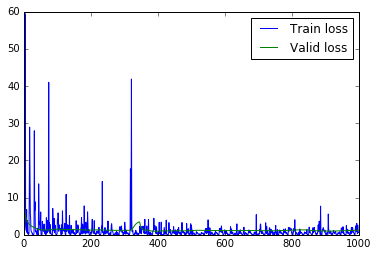

In [9]:
# Display the learning curve and losses for training, validation, and testing
% matplotlib inline
import matplotlib.pyplot as plt

plt.plot(net.losses['train'], label='Train loss')
plt.plot(net.losses['valid'], label='Valid loss')
plt.legend()

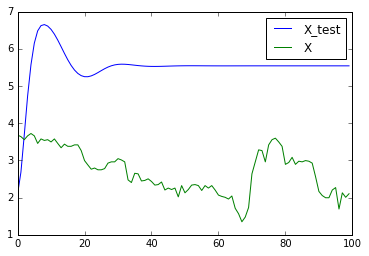

In [12]:
mb = get_minibatch(X=X_valid, y=Y_valid, minibatch_size=time_step, shuffle=False)
# len(mb)
X, Y = mb[len(mb)//100]
# X.shape, Y.shape
state = net.initial_state()
X_test = net.test(X_seed=X[0], h=state, size=time_step)
# len(X_test)
X_test = np.array(X_test)
X = np.array(X)
# X_test.shape, X.shape
plt.plot(X_test[:, :, 1], label='X_test')
plt.plot(X[:, 1], label='X')
plt.legend()